# Decision Tree 
In this notebook, we implement a decision tree algorithm for [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) from scratch.

<img src="./images/iris.svg" alt="iris-image"></img>

Table of Contents
<ul>
<li><a href="#read-data">Read Data</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#preprocesing">Preprocessing</a></li>
<li><a href="#entropy">Helper Functions</a></li>
<li><a href="#dt">Decision Tree Algorithm from Scratch</a></li>
<li><a href="#dt-iris">Decision Tree on Iris Dataset</a></li>
</ul>

In [1]:
# import packages
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Read data <a id="read-data"></a>

In [2]:
names = [
    'sepal-length',
    'sepal-width',
    'petal-length',
    'petal-width',
    'class',
]


df = pd.read_csv(
    './data/iris.data',
    header=None,
    names=names,
)

df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Exploratory Data Analysis (EDA) <a id="eda"></a>

The columns `sepal-length`, `sepal-width`, `petal-length` and `petal-width` are features and the `class` is the target we want to predict. Let's first investiages dataset for missing values.

### Missing values

In [3]:
df.isna().any().sum()

0

The `df.isna().any().sum()` results to 0, which indicates that there isn't any missing values in any columns of the Iris dataset.

### Data Visualizations

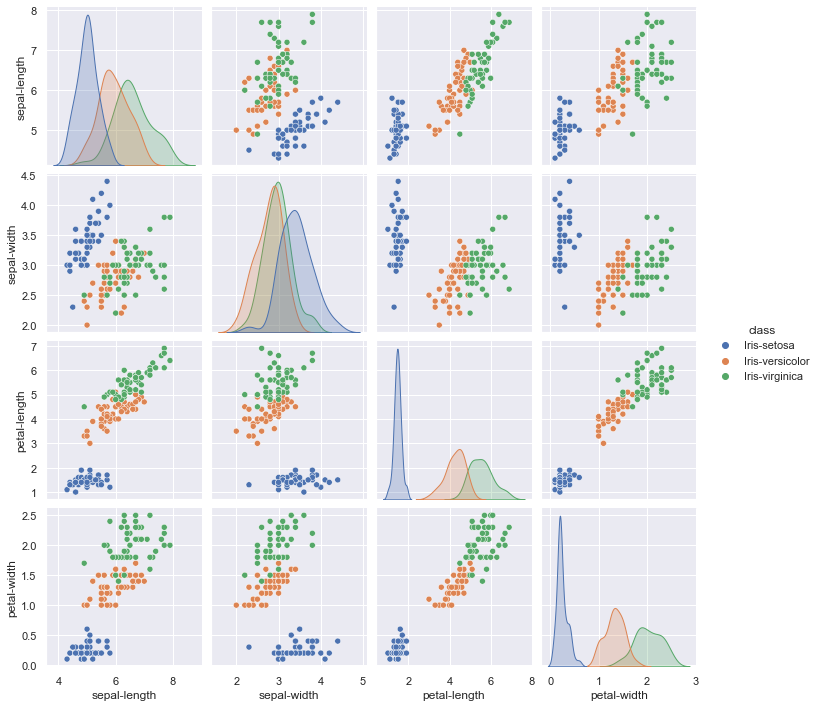

In [4]:
_ = sns.pairplot(data=df, hue='class')

These plots shows that `Iris-setosa` can be identified with `petal-length`. In addition, the plots shows that we can come up with classification boundries to distinguish `Iris-versicolor` from `Iris-viginica`.

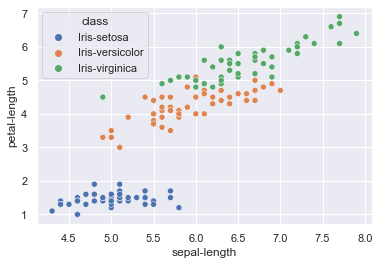

In [5]:
_ = sns.scatterplot(x='sepal-length', y='petal-length', data=df, hue='class')

From the visualiztions we see that there are 3 distinct categories. We can cross check that with the following:

In [6]:
df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

## Preprocessing <a id="preprocesing"></a>

In order to use machine learning to predict class of Iris flower, we need to convert all categorical features to numerical ones.

In [7]:
df_numeric = pd.get_dummies(df, prefix='', prefix_sep='')
df_numeric

,sepal-length,sepal-width,petal-length,petal-width,Iris-setosa,Iris-versicolor,Iris-virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,0,1
146,6.3,2.5,5.0,1.9,0,0,1
147,6.5,3.0,5.2,2.0,0,0,1
148,6.2,3.4,5.4,2.3,0,0,1


Let's combine the 3 columns to 1 column for simplicty

In [8]:
def find_numeric_class(row):
    if row['Iris-setosa'] == 1:
        return -1
    elif row['Iris-versicolor'] == 1:
        return 0
    elif row['Iris-virginica'] == 1:
        return 1
    else:
        raise ValueError("Each row must belong to one of the 3 Iris categories")
    
df_numeric['numeric_class'] = df_numeric.apply(lambda row: find_numeric_class(row), axis=1)

In [9]:
df_numeric.drop(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], inplace=True, axis=1)

In [10]:
df_numeric

,sepal-length,sepal-width,petal-length,petal-width,numeric_class
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1


Now we split dataset to train and test data using `scikit learn`'s `train_test_split` function.

In [11]:
from sklearn.model_selection import train_test_split

X = df_numeric.drop(['numeric_class'], axis=1).values
y = df_numeric['numeric_class'].values


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=41,
    shuffle=True,
    stratify=y,
)

## Helper Functions <a id="entropy"></a>

In this section, we define entropy and information gains which will be used in decision tree algorithms.

In [12]:
def entropy(datapoints):
    """Finds the entropy for dataset
    
    datapoints: list
        datapoints is the list of integer values.
        
    Example:
    >>> datapoint = [1,1,1,0,-1,-1]
    >>> entropy(datapoints)
    1.0114042647073518
    """
    # check validity of datapoints
    assert type(datapoints) == list
    for item in datapoints:
        assert type(item) == int
    
    # count number of occurence of each value
    from collections import Counter
    counts = Counter(datapoints)
    
    total_datapoints = len(datapoints)
    entropy_ = 0
    
    for key, value in counts.items():
        pi = value/total_datapoints 
        entropy_ += - pi * np.log(pi)
        
    return entropy_
    

def information_gain(data_original, data_split_1, data_split_2):
    """Information gain in data split.
    
    Example:
    >>> information_gain([1,1,1,0,-1,-1], [1,1,1,0], [-1,-1])
    0.4490691200885435
    """
    return entropy(data_original) - entropy(data_split_1) - entropy(data_split_2)

## Decision Tree Algorithm from Scratch <a id="dt"></a>

In this section, we implement the decision tree algorithm from scratch.

In [13]:
class Node:
    """A class to represent each node of a tree data structure.
    
    A node is either a decision node or a leaf node.
    A leaf node is a node which don't have any child nodes.
    A decision node is a node which have child node or children nodes.
    
    """
    
    def __init__(
        self,
        feature_index=None,
        threshold=None,
        left=None,
        right=None,
        information_gain=None,
        value=None,
        depth=None,
    ):
    
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.information_gain = information_gain
    
        self.value = value
        
    def is_leaf(self):
        """Determines whether the node is a leaf
        """
        if self.value is None:
            return False
        else:
            return True
    
    def is_decision_node(self):
        """Determines whether the node is a decision node.
        """
        return not self.is_leaf()
    
    def __str__(self):
        if self.is_leaf():
            return f"node = {value}"
        else:
            return str(self.feature_index) + " - " + str(self.threshold)

In [14]:
class DecisionTree:
    
    def __init__(self, min_samples_split, max_depth):
        """Constructor of the Decision Tree
        
        Parameters
        ----------
        min_samples_split (int): determines the minimum number of datapoints
            in order to split a node. If number of datapoints is less than
            `min_samples_split` then the node will be considered to be a
            leaf node, otherwise, it will be a decision node.
                
        max_depth (int): determines the maximum depth of splits in the tree.
        
        """
        
        # root of the tree (the node which don't have any parents)
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    @property
    def min_samples_split(self):
        return self._min_samples_split
    
    @min_samples_split.setter
    def min_samples_split(self, min_samples_split):
        assert min_samples_split > 0
        assert type(min_samples_split) == int
        self._min_samples_split = min_samples_split
        
    @property
    def max_depth(self):
        return self._max_depth
    
    @max_depth.setter
    def max_depth(self, max_depth):
        assert max_depth > 0
        assert type(max_depth) == int
        self._max_depth = max_depth
        
    def split(self, X, y, feature_index, threshold):
        """
        Parameters
        ----------
        X : numpy.ndarray
            Array of features
            
        y : numpy.ndarray
            Array of targets
            
        feature_index : int
            Index of feature (the column in X array)
            
        threshold : float
            The value to split the array based on this feature
            
            
        Returns
        -------
        lX, ly, rX, ry : numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray
            The splitted features and target arrays
            
        """
        left_indices = np.where(X[:, feature_index] < threshold)
        right_indices = np.where(X[:, feature_index] >= threshold)
        rX = X[right_indices]
        ry = y[right_indices]
        lX = X[left_indices]
        ly = y[left_indices]
        return lX, ly, rX, ry
    
    def _get_information_gain_of_an_split(self, X, y, lX, ly, rX, ry):
        """Returns the information gain of splitted arrays
        """
        return information_gain(y.tolist(), ly.tolist(), ry.tolist())
    
    def _optimze_split(self, X, y):
        """Returns optimized split parameters.
        
        The function loops over possible feature_indices of X and possible
        threshold candidates and returns the parameters that maximizes the
        information gain.
        
        Parameters
        ----------
        X : numpy.ndarray
            Array of features
            
        y: numpy.ndarray
            Array of targets
            
        Returns
        -------
        optimum_feature, optimum_threshold, best_information_gain: int, float, float
        
        """
        n_records, n_features = X.shape
        
        optimum_feature = None
        optimum_threshold = None
        best_information_gain = None
        
        for feature_index in range(n_features):
            
            # get all unique values for an index
            index_values = np.sort(np.unique(X[:, feature_index])).tolist()
            
            # loop over value of thresholds
            for threshold in index_values:
            
                lX, ly, rX, ry = self.split(X, y, feature_index, threshold)

                temp_information_gain = self._get_information_gain_of_an_split(X, y, lX, ly, rX, ry)

                if best_information_gain is None:            
                    best_information_gain = temp_information_gain
                    optimum_feature = feature_index
                    optimum_threshold = threshold
                else:
                    if best_information_gain <= temp_information_gain:
                        best_information_gain = temp_information_gain
                        optimum_feature = feature_index
                        optimum_threshold = threshold
                        
        return optimum_feature, optimum_threshold, best_information_gain
    
    def _fit_node(self, X, y, node):
        
        """fits the `node` by `X` features and `y` targets.
        
        
        Parametes
        ---------
        X : numpy.ndarray
        
        y : numpy.ndarray or list
        
        node : Node
        
        """
        
        if X.shape[0] <= self.min_samples_split or node.depth <= 0:

            ys = y.tolist()
            # in this case the node is a leaf node
            if ys:
                value = Counter(ys).most_common()[0][0]
                node.value = value
            else:
                node.value = np.nan
            return node
        else:
            # in this case the node is a decision node
            
            # define to split nodes
            left_node = Node()
            right_node = Node()
            
            # find optimum decision
            optimum_feature, optimum_threshold, best_information_gain = self._optimze_split(X, y)
            # assing optimum values to node
            node.feature_index = optimum_feature
            node.threshold = optimum_threshold
            node.information_gain = best_information_gain
            # assign nodes, left and right splits
            node.left = left_node
            node.right = right_node
            left_node.depth = node.depth - 1
            right_node.depth = node.depth -1 
            
            lX, ly, rX, ry = self.split(
                X=X,
                y=y ,
                feature_index=optimum_feature,
                threshold=optimum_threshold,
            )
            if lX.shape[0] == 0:
                node.left = None
            else:
                self._fit_node(lX, ly, left_node)
            if rX.shape[0] == 0:
                node.right = None
            else:
                self._fit_node(rX, ry, right_node)
            return node
        
    def fit(self, X, y):
        """Fits the parameters of the decision tree.
        
        Parametes
        ---------
        X : numpy.ndarray
        
        y : numpy.ndarray or list
        
        
        """
        if self.root is None:
            self.root = Node()
            self.root.depth = self.max_depth
        return self._fit_node(X, y, self.root)
    
    def _predict(self, x, node):
        """Predicts the leaf node value for `x` when it is passed to `node`.
        
        The `x` is just one row of features and not features of more than on record.
        """
        if node.is_leaf():
            return node.value
        else:
            if x[node.feature_index] < node.threshold:
                return self._predict(x, node.left)
            elif x[node.feature_index] >= node.threshold:
                return self._predict(x, node.right)
    
    
    def predict(self, X):
        """Returns predictions for features
        
        Parameters
        ----------
        X : numpy.ndarray
        
        Returns
        -------
        preds : list
        """
        preds = []
        for x in X:
            preds.append(self._predict(x, self.root))
        return preds
    
    def get_accuracy(self, X, y):
        """Returns the accuracy of prediction
        
        Parametes
        ---------
        X : numpy.ndarray
        
        y : numpy.ndarray or list
        
        Returns
        -------
        float
        
        """
        preds = self.predict(X)
        return np.sum(y - preds == 0)/len(preds)

## Decision Tree on Iris Dataset <a id="dt-iris"></a>

In this section, we train a decision tree algorithm on Iris dataset.

In [15]:
# Construct a decision tree model
model = DecisionTree(min_samples_split=10, max_depth=3)
# fit the model with train data
model.fit(X_train, y_train)
# evaluate the accuracy of the model for train dataset
train_acc = model.get_accuracy(X_train, y_train)
# evalueate the accuracy of the model for test dataset
test_acc = model.get_accuracy(X_test, y_test)
# print results
print(f"Accuracy of Train dataset = {train_acc:.2}")
print(f"Accuracy of Test dataset = {test_acc:.2}")

Accuracy of Train dataset = 0.98
Accuracy of Test dataset = 0.9


We achieve accuracy of $98\%$ on train set and $90\%$ on the test set with this simple implementation of a decision tree algorithm.